# Fine-tuning SmolVLM on ChartLlama Dataset

This notebook demonstrates how to fine-tune the SmolVLM model on the ChartLlama dataset using parameter-efficient fine-tuning (LoRA).

In [6]:
import os
#os.chdir('/content/drive/MyDrive/code')
os.chdir('/home/ricky732/CS7643_final_project/working_dir')

In [7]:
# Core dependencies
!pip install -U datasets
!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U trl  # latest TRL library from HuggingFace
!pip install -q flash-attn --no-build-isolation
!pip install -q word2number


In [8]:
# Standard libraries
import os
import sys
import json
import gc
import time
import traceback
import re
import string
import math
from pathlib import Path
from functools import reduce
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union
from itertools import islice

# Data science & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm.notebook import tqdm

# Image processing
from PIL import Image

# Data handling
from datasets import Dataset, load_dataset
from accelerate.utils import set_seed
from word2number import w2n

# Hugging Face transformers
from transformers import (
    AutoProcessor,
    Idefics3ForConditionalGeneration,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoConfig
)

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    PeftModel
)

# TRL (Training utilities)
from trl import SFTTrainer, SFTConfig

# Experiment tracking
import wandb
import torch

In [9]:
print("--- Setting Configuration --- ")

# --- Basic Setup ---
#WORKING_DIR = '/content/drive/MyDrive/code'
WORKING_DIR = '/home/ricky732/CS7643_final_project/working_dir'
DATA_DIR = Path("./chartllama_data")
OUTPUT_DIR_BASE_NAME = "smolvlm-chartllama-sft-refactored-short-prompt" # change to short prompt for short prompt
# OUTPUT_DIR_BASE_NAME = "smolvlm-chartllama-sft-refactored"
SEED = 42
set_seed(SEED)

--- Setting Configuration --- 


In [10]:
if os.getcwd() != WORKING_DIR:
    print(f"Changing working directory to: {WORKING_DIR}")
    os.makedirs(WORKING_DIR, exist_ok=True)
    os.chdir(WORKING_DIR)
else:
    print(f"Already in working directory: {WORKING_DIR}")


Already in working directory: /home/ricky732/CS7643_final_project/working_dir


In [11]:
MODEL_ID = "HuggingFaceTB/SmolVLM-Instruct" # specify model to use here

USE_LORA = True
USE_QLORA = False

LORA_R = 8 # rank set to 8
LORA_ALPHA = 8
LORA_DROPOUT = 0.1
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", # attention heads
                       "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"
                       ]

In [12]:
if USE_QLORA and not USE_LORA:
    print("Warning: USE_QLORA=True requires USE_LORA=True. Forcing USE_LORA=True.")
    USE_LORA = True

In [13]:
# --- Training Hyperparameters ---
NUM_TRAIN_EPOCHS = 3 # keep to default
PER_DEVICE_TRAIN_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4
LEARNING_RATE = 1e-4
MAX_SEQ_LENGTH = 2048
OPTIMIZER = "adamw_torch_fused"
LR_SCHEDULER_TYPE = "cosine"
LOGGING_STEPS = 25
SAVE_STRATEGY = "epoch"
EVAL_STRATEGY = "epoch"
EVAL_STEPS = 50
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
SAMPLE_LIMIT = None # training sample limit on Chartllama, None will use everything available.

In [14]:
# --- Resources & Precision ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
ATTN_IMPLEMENTATION = "flash_attention_2"

In [15]:
# --- Output Directory (Directly on Drive) ---
if not USE_LORA:
    TRAINING_TYPE = "full-tuned"
elif USE_QLORA:
    TRAINING_TYPE = "qlora-tuned"
else:
    TRAINING_TYPE = "lora-tuned"

In [16]:
model_name_short = MODEL_ID.split('/')[-1]
output_folder_name = f"{OUTPUT_DIR_BASE_NAME}-{model_name_short}-{TRAINING_TYPE}-paddingTrue" # test for lora alpha 16
OUTPUT_DIR = os.path.join(WORKING_DIR, output_folder_name) # full path on Drive
FINAL_MODEL_DIR = os.path.join(OUTPUT_DIR, "final_model")
FINAL_PROCESSOR_DIR = os.path.join(OUTPUT_DIR, "final_processor") # sub directory to save processor

In [17]:
# --- Evaluation Config ---
CHARTQA_DATASET_ID = "HuggingFaceM4/ChartQA"
EVAL_SPLIT = "test"
EVAL_LIMIT = None # number of chartqa samples to use when evaluating ChartQA
MAX_NEW_TOKENS_EVAL = 32
EVAL_OUTPUT_FILE = os.path.join(OUTPUT_DIR, "chartqa_evaluation_results_comparison.json")

In [22]:
# --- W&B Logging ---
#WANDB_PROJECT = "smolvlm-chartllama-sft-refactored" # Set to None to disable
WANDB_PROJECT = None
WANDB_RUN_NAME = f"{model_name_short}-{TRAINING_TYPE}-{int(time.time())}" # Unique name for run


In [23]:
# Create output directory now (important for direct-to-drive)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory ensured: '{OUTPUT_DIR}'")

# display summary of all relevant information based on above settings.
# --- Print Summary ---
print(f"\n--- Configuration Summary ---")
print(f"Model ID: {MODEL_ID}")
print(f"Training Type: {TRAINING_TYPE}")
print(f"Use LoRA: {USE_LORA}, Use QLoRA: {USE_QLORA}")
print(f"Device: {DEVICE}, Compute Dtype: {DTYPE}, Attention: {ATTN_IMPLEMENTATION}")
print(f"Learning Rate: {LEARNING_RATE}, Epochs: {NUM_TRAIN_EPOCHS}")
print(f"Eval Strategy: {EVAL_STRATEGY}")
print(f"Output Directory (on Drive): '{OUTPUT_DIR}'")
print(f"Final Model Save Directory: '{FINAL_MODEL_DIR}'")
print(f"Final Processor Save Directory: '{FINAL_PROCESSOR_DIR}'")
print(f"Evaluation results file: {EVAL_OUTPUT_FILE}")
print(f"WandB Project: {WANDB_PROJECT}, Run Name: {WANDB_RUN_NAME}")
print("-----------------------------")

print("\n--- Full Configuration Complete --- ")

print("\n--- Configuration Complete --- ")


Output directory ensured: '/home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue'

--- Configuration Summary ---
Model ID: HuggingFaceTB/SmolVLM-Instruct
Training Type: lora-tuned
Use LoRA: True, Use QLoRA: False
Device: cuda, Compute Dtype: torch.bfloat16, Attention: flash_attention_2
Learning Rate: 0.0001, Epochs: 3
Eval Strategy: epoch
Output Directory (on Drive): '/home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue'
Final Model Save Directory: '/home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue/final_model'
Final Processor Save Directory: '/home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue/final_processor'
Evaluation results file: /home/ricky732/CS7643_fin

In [24]:
# api key: 0469802d14d997b8dad4d23a7ba212e0a8d8f197
# --- Simplified WandB setup ---
print("--- WandB Setup ---")

if WANDB_PROJECT:
    try:
        wandb.login(relogin=False)
        wandb.init(
            project=WANDB_PROJECT,
            name=WANDB_RUN_NAME,
            config={
                "model_id": MODEL_ID,
                "training_type": TRAINING_TYPE,
                "use_lora": USE_LORA,
                "use_qlora": USE_QLORA,
                "dtype": str(DTYPE),
                "seed": SEED,
                "lora_r": LORA_R if USE_LORA else None,
                "lora_alpha": LORA_ALPHA if USE_LORA else None,
                "num_epochs": NUM_TRAIN_EPOCHS,
                "learning_rate": LEARNING_RATE,
                "batch_size": PER_DEVICE_TRAIN_BATCH_SIZE,
                "grad_accum": GRADIENT_ACCUMULATION_STEPS,
                "max_seq_length": MAX_SEQ_LENGTH,
                "output_dir": OUTPUT_DIR,
                "optimizer": OPTIMIZER,
                "lr_scheduler": LR_SCHEDULER_TYPE,
                "warmup_ratio": WARMUP_RATIO,
                "weight_decay": WEIGHT_DECAY,
            },
            job_type="fine-tuning"
        )
        print("WandB initialized.")
    except Exception as e:
        print(f"WandB initialization failed: {e}. Disabling WandB.")
        os.environ["WANDB_DISABLED"] = "true"
else:
    print("WandB disabled by configuration (WANDB_PROJECT=None).")
    os.environ["WANDB_DISABLED"] = "true"

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("--- WandB Setup Complete ---")

--- WandB Setup ---
WandB disabled by configuration (WANDB_PROJECT=None).
--- WandB Setup Complete ---


In [25]:
# --- Define chartllama data loading function ---

print("\n--- Defining Data Loading Function ---")

def load_chartllama_data(data_root: Path, image_root: Path, limit: Optional[int] = None):
    """Loads ChartLlama QA pairs from JSON files."""
    if not data_root.is_dir():
        raise FileNotFoundError(f"Data root directory not found: {data_root.resolve()}")

    examples, skipped = [], 0
    json_files = list(data_root.glob("*_simplified_qa.json"))

    if not json_files:
        raise FileNotFoundError(f"No '*_simplified_qa.json' files found in {data_root}")

    for json_file in tqdm(json_files, desc="Processing JSON files"):
        with open(json_file, "r", encoding="utf-8") as f:
            qa_list = json.load(f)

        for idx, qa in enumerate(qa_list):
            if limit and len(examples) >= limit:
                break

            question = qa.get("conversations", [{}])[0].get("value", "").replace("<image>", "").strip()
            answer = qa.get("conversations", [{}, {}])[1].get("value", "").strip()
            image_path = (image_root / qa.get("image", "")).resolve()

            if question and answer and image_path.is_file():
                examples.append({
                    "id": qa.get("id", f"{json_file.stem}_{idx}"),
                    "question": question,
                    "answer": answer,
                    "image_path": str(image_path),
                })
            else:
                skipped += 1

    if not examples:
        raise ValueError(f"No valid examples loaded from {data_root}. Skipped {skipped} samples.")

    print(f"\nLoaded {len(examples)} examples. Skipped {skipped} invalid samples.")
    return Dataset.from_list(examples)

print("Data loading function defined.")



--- Defining Data Loading Function ---
Data loading function defined.


In [27]:
# --- Load Chartllama data ---

print("\n--- Loading and Splitting Data ---")
train_dataset, eval_dataset, raw_dataset = None, None, None

# ensure DATA_DIR is a valid Path object
DATA_DIR = Path(DATA_DIR)
if not DATA_DIR.is_absolute():
    DATA_DIR = Path(WORKING_DIR) / DATA_DIR

if not DATA_DIR.is_dir():
    raise FileNotFoundError(f"Input data directory not found: {DATA_DIR.resolve()}")

print(f"Loading data from: {DATA_DIR.resolve()}")
raw_dataset = load_chartllama_data(DATA_DIR, DATA_DIR, limit=SAMPLE_LIMIT)

if not raw_dataset:
    raise RuntimeError("Data loading returned an empty dataset.")

# split dataset: 80% train, 20% validation
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=SEED, shuffle=True)
train_dataset, eval_dataset = dataset_split["train"], dataset_split["test"]

print(f"\nRaw data loaded and split.")
print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples (Validation): {len(eval_dataset)}")

# display one sample from train dataset
if train_dataset:
    print("\nSample train data point (raw):")
    print(train_dataset[0])
else:
    print("Train dataset is empty after split.")


--- Loading and Splitting Data ---
Loading data from: /home/ricky732/CS7643_final_project/working_dir/chartllama_data


Processing JSON files:   0%|          | 0/7 [00:00<?, ?it/s]


Loaded 980 examples. Skipped 0 invalid samples.

Raw data loaded and split.
Train samples: 784
Eval samples (Validation): 196

Sample train data point (raw):
{'id': 'ours_simplified_qa_35_2', 'question': 'What is the mortality rate for Neonatal mortality (under-28 days)?', 'answer': '4.6', 'image_path': '/home/ricky732/CS7643_final_project/working_dir/chartllama_data/ours/funnel_chart/png/funnel_chart_100examples_35.png'}


In [28]:
# ### 3.1 Load Model and Processor

print("\n--- Loading Model and Processor for Training ---")

# load Processor
print(f"Loading processor for model: {MODEL_ID}")
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token
    if hasattr(processor, 'pad_token') and processor.pad_token is None:
        processor.pad_token = processor.tokenizer.eos_token
print("Processor loaded.")

# configure Model Loading
print("\nConfiguring model loading...")
model_load_kwargs = {"device_map": "auto", "torch_dtype": DTYPE}

if USE_LORA and USE_QLORA:
    print("Configuring model for QLoRA (4-bit).")
    model_load_kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=DTYPE
    )
elif USE_LORA:
    print(f"Configuring model for LoRA (dtype: {DTYPE}).")
else:
    print(f"Configuring model for Full Fine-Tuning (dtype: {DTYPE}).")

# load Config
config = AutoConfig.from_pretrained(MODEL_ID, trust_remote_code=True, use_cache=False)
if hasattr(config, "attn_implementation"):
    config.attn_implementation = ATTN_IMPLEMENTATION

# load Model
print(f"Loading model '{MODEL_ID}'...")
model = Idefics3ForConditionalGeneration.from_pretrained(
    MODEL_ID, config=config, trust_remote_code=True, **model_load_kwargs
)

print("Model loaded.")
print(f"  - Device Map: {getattr(model, 'hf_device_map', model.device)}")
print(f"  - Attention Implementation: {getattr(model.config, 'attn_implementation', 'N/A')}")

# PEFT Setup
if USE_LORA:
    print("\nApplying PEFT/LoRA configuration...")
    if USE_QLORA:
        model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True, gradient_checkpointing_kwargs={"use_reentrant": False})
        model.config.use_cache = False
    elif hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
        model.config.use_cache = False

    peft_config = LoraConfig(
        r=LORA_R, lora_alpha=LORA_ALPHA, lora_dropout=LORA_DROPOUT,
        target_modules=LORA_TARGET_MODULES, bias="none", task_type="CAUSAL_LM"
    )

    if not isinstance(model, PeftModel):
        model = get_peft_model(model, peft_config)
        model.print_trainable_parameters()
else:
    if hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
        model.config.use_cache = False

print("\n--- Model and Processor Setup Complete ---")


--- Loading Model and Processor for Training ---
Loading processor for model: HuggingFaceTB/SmolVLM-Instruct
Processor loaded.

Configuring model loading...
Configuring model for LoRA (dtype: torch.bfloat16).
Loading model 'HuggingFaceTB/SmolVLM-Instruct'...
Model loaded.
  - Device Map: {'': 0}
  - Attention Implementation: N/A

Applying PEFT/LoRA configuration...
trainable params: 10,946,584 || all params: 2,257,219,464 || trainable%: 0.4850

--- Model and Processor Setup Complete ---


In [30]:
# ### 3.1 define smolvlm formatting functions and collate_fn

print("\n--- Defining Formatting Function & Data Collator ---")

SYSTEM_MESSAGE = """You are a Vision Language Model specialized in interpreting visual data from chart images. Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase. The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text. Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""
#SYSTEM_MESSAGE = """You are a Vision-Language Model specialized in interpreting chart images. Please answer the question using only one word or a number based on the provided chart."""

def create_chat_messages(sample):
    """Creates the chat message structure for SFT training."""
    question = sample.get("question")
    answer = sample.get("answer")
    if question is None or answer is None:
         return None

    return [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_MESSAGE}]},
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": question}
        ]},
        {"role": "assistant", "content": [{"type": "text", "text": answer}]},
    ]


@dataclass # ChartLlama collator class for collate function
class ChartLlamaCollator:
    processor: AutoProcessor
    max_seq_length: int = MAX_SEQ_LENGTH

    def __post_init__(self):
        image_token_str = "<image>"
        self.image_token_id = self.processor.tokenizer.convert_tokens_to_ids(image_token_str)
        if self.image_token_id is None:
            self.image_token_id = -100

    def __call__(self, examples: List[Dict[str, Any]]) -> Dict[str, Any]:
        pil_images, texts = [], []

        for ex in examples:
            img_path = ex.get('image_path')
            if not img_path or not os.path.exists(img_path):
                continue

            img = Image.open(img_path).convert("RGB")
            messages = create_chat_messages(ex)
            if messages is None:
                continue

            formatted_text = self.processor.apply_chat_template(
                messages, add_generation_prompt=False, tokenize=False
            )

            pil_images.append(img)
            texts.append(formatted_text)

        if not texts or not pil_images:
            return {"input_ids": torch.tensor([], dtype=torch.long)}

        batch = self.processor(
            text=texts,
            images=pil_images,
            return_tensors="pt",
            padding=True,
            # truncation=True,
            # max_length=self.max_seq_length,
        )

        labels = batch["input_ids"].clone()
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        if self.image_token_id != -100:
            labels[labels == self.image_token_id] = -100

        batch["labels"] = labels
        return batch

chart_collator = ChartLlamaCollator(processor=processor)
print("\nCustom Collator instantiated.")


--- Defining Formatting Function & Data Collator ---

Custom Collator instantiated.


In [31]:
# configure training arguments
print("\n--- Configuring Training Arguments ---")

if 'OUTPUT_DIR' not in locals():
    raise NameError("OUTPUT_DIR not defined. Rerun configuration cell.")

trainer_config = SFTConfig(
    output_dir=OUTPUT_DIR,
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_text_field="",
    packing=False,
    dataset_kwargs={"skip_prepare_dataset": True},

    num_train_epochs=NUM_TRAIN_EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},

    optim=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type=LR_SCHEDULER_TYPE,

    logging_strategy="steps",
    logging_steps=LOGGING_STEPS,
    save_strategy=SAVE_STRATEGY,
    save_total_limit=2,
    save_only_model=("peft_config" in locals() and peft_config is not None),

    bf16=(DTYPE == torch.bfloat16),
    fp16=(DTYPE == torch.float16),

    eval_strategy=EVAL_STRATEGY,
    eval_steps=EVAL_STEPS,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    seed=SEED,
    report_to="wandb" if WANDB_PROJECT and os.environ.get("WANDB_DISABLED") != "true" else "none",
    remove_unused_columns=False,
)

print("SFTConfig set.")


--- Configuring Training Arguments ---
SFTConfig set.


In [32]:
# initialize trainer

print("\n--- Initializing SFTTrainer ---")

required_components = [train_dataset, model, trainer_config, chart_collator, processor]

if all(required_components):
    trainer = SFTTrainer(
        model=model,
        args=trainer_config,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset if EVAL_STRATEGY != "no" else None,
        data_collator=chart_collator,
        peft_config=peft_config if USE_LORA else None,
    )
    print("SFTTrainer initialized successfully.")
else:
    missing = [name for name, comp in zip(
        ['train_dataset', 'model', 'trainer_config', 'chart_collator', 'processor'],
        required_components) if comp is None]
    raise RuntimeError(f"Cannot initialize trainer. Missing components: {', '.join(missing)}")


--- Initializing SFTTrainer ---


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


SFTTrainer initialized successfully.


In [33]:
# --- Run Training (with Loss curve Plotting Added & Enhanced Naming) ---

print("\n--- Checking if Training Should Be Skipped ---")

model_exists = os.path.isdir(FINAL_MODEL_DIR) and any(
    f.endswith(('.bin', '.safetensors', 'adapter_config.json')) for f in os.listdir(FINAL_MODEL_DIR)
)

processor_exists = os.path.isfile(os.path.join(FINAL_PROCESSOR_DIR, "preprocessor_config.json"))

if model_exists and processor_exists:
    print("Model and processor already exist. Skipping training.")
else:
    if trainer is None or processor is None:
        raise RuntimeError("Trainer or processor not available. Cannot proceed with training.")

    print("Starting training...")
    start_time = time.time()

    os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
    os.makedirs(FINAL_PROCESSOR_DIR, exist_ok=True)

    train_result = trainer.train()

    print(f"Training completed in {(time.time() - start_time)/60:.2f} minutes.")

    trainer.save_model(FINAL_MODEL_DIR)
    processor.save_pretrained(FINAL_PROCESSOR_DIR)

    trainer.log_metrics("train", train_result.metrics)
    trainer.save_metrics("train", train_result.metrics)
    trainer.save_state()

    log_history = trainer.state.log_history
    if log_history:
        log_df = pd.DataFrame(log_history)
        fig, ax = plt.subplots(figsize=(12, 7))

        if 'loss' in log_df:
            ax.plot(log_df['step'], log_df['loss'], label='Training Loss', marker='o')
        if 'eval_loss' in log_df:
            ax.plot(log_df['step'], log_df['eval_loss'], label='Validation Loss', marker='s')

        ax.set_title(f"Training & Validation Loss ({model_name_short}, {TRAINING_TYPE})")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

        plot_path = os.path.join(OUTPUT_DIR, f"loss_curves_{model_name_short}_{TRAINING_TYPE}.png")
        fig.savefig(plot_path, dpi=150)
        plt.close(fig)

# Cleanup
del trainer
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n--- Training Step Execution Finished ---")



--- Checking if Training Should Be Skipped ---
Starting training...


Epoch,Training Loss,Validation Loss
1,1.806900,0.639055
2,0.332800,0.149889
3,0.135700,0.137089


/home/ricky732/anaconda3/envs/py10_vlm2/lib/python3.10/site-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


Training completed in 308.30 minutes.
***** train metrics *****
  total_flos               = 39667763GF
  train_loss               =     0.6136
  train_runtime            = 5:08:17.57
  train_samples_per_second =      0.127
  train_steps_per_second   =      0.008

--- Training Step Execution Finished ---


In [34]:
# --- Load Fine-tuned Model ---
print("\n--- Setting up Evaluation Environment ---")

FT_MODEL_LOAD_PATH = FINAL_MODEL_DIR
PROCESSOR_LOAD_PATH = FINAL_PROCESSOR_DIR

print(f"Loading processor from: {PROCESSOR_LOAD_PATH}")

if not os.path.isdir(PROCESSOR_LOAD_PATH):
    raise FileNotFoundError(f"Processor directory not found: {PROCESSOR_LOAD_PATH}")

eval_processor = AutoProcessor.from_pretrained(PROCESSOR_LOAD_PATH, trust_remote_code=True)

if eval_processor.tokenizer.pad_token_id is None:
    eval_processor.tokenizer.pad_token = eval_processor.tokenizer.eos_token
    if hasattr(eval_processor, 'pad_token') and eval_processor.pad_token is None:
        eval_processor.pad_token = eval_processor.tokenizer.eos_token

print("Processor loaded successfully.")


--- Setting up Evaluation Environment ---
Loading processor from: /home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue/final_processor
Processor loaded successfully.


In [35]:
# --- Load Fine-tuned Model ---

eval_model = None
if not eval_processor:
    raise RuntimeError("Processor is not loaded. Cannot load model.")

if not os.path.isdir(FT_MODEL_LOAD_PATH):
    raise FileNotFoundError(f"Fine-tuned model directory not found: {FT_MODEL_LOAD_PATH}")

# Load evaluation configuration
try:
    eval_config = AutoConfig.from_pretrained(FT_MODEL_LOAD_PATH, trust_remote_code=True)
except OSError:
    eval_config = AutoConfig.from_pretrained(MODEL_ID, trust_remote_code=True)

eval_config.use_cache = True
if hasattr(eval_config, "attn_implementation"):
    eval_config.attn_implementation = ATTN_IMPLEMENTATION

load_kwargs = {"device_map": "auto", "torch_dtype": DTYPE}

if USE_LORA:
    # Ensure pad_token consistency
    pad_token_id = eval_processor.tokenizer.pad_token_id
    base_config = AutoConfig.from_pretrained(MODEL_ID, trust_remote_code=True)

    config_to_modify = base_config.text_config if hasattr(base_config, 'text_config') else base_config
    config_to_modify.pad_token_id = pad_token_id
    config_to_modify.vocab_size = max(config_to_modify.vocab_size, pad_token_id + 1)

    base_config.use_cache = True
    if hasattr(base_config, "attn_implementation"):
        base_config.attn_implementation = ATTN_IMPLEMENTATION

    if USE_QLORA:
        load_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=DTYPE)

    base_model = Idefics3ForConditionalGeneration.from_pretrained(MODEL_ID, config=base_config, trust_remote_code=True, **load_kwargs)
    eval_model = PeftModel.from_pretrained(base_model, FT_MODEL_LOAD_PATH)
else:
    eval_model = Idefics3ForConditionalGeneration.from_pretrained(FT_MODEL_LOAD_PATH, config=eval_config, trust_remote_code=True, **load_kwargs)

# Prepare model for evaluation
eval_model.eval()
print("Fine-tuned model loaded successfully.")

Fine-tuned model loaded successfully.


In [36]:
# --- Load Base Model for Evaluation ---

if eval_processor is None:
    raise RuntimeError("Processor is not loaded; cannot load base model.")

base_model_config = AutoConfig.from_pretrained(MODEL_ID, trust_remote_code=True)
base_model_config.use_cache = True

if hasattr(base_model_config, "attn_implementation"):
    base_model_config.attn_implementation = ATTN_IMPLEMENTATION

base_load_kwargs = {"device_map": "auto", "torch_dtype": DTYPE}

base_model_eval = Idefics3ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    config=base_model_config,
    trust_remote_code=True,
    **base_load_kwargs
)

base_model_eval.eval()
print("Base model loaded successfully.")

Some parameters are on the meta device because they were offloaded to the cpu.


Base model loaded successfully.


In [37]:
# --- Load Evaluation Dataset (ChartQA) ---
chartqa_test_dataset = None
if eval_processor:
    try:
        print(f"\nLoading evaluation dataset '{CHARTQA_DATASET_ID}' split '{EVAL_SPLIT}'...")
        chartqa_test_iterable = load_dataset(CHARTQA_DATASET_ID, split=EVAL_SPLIT, streaming=False)

        if EVAL_LIMIT is not None and EVAL_LIMIT > 0:
            chartqa_test_list = list(chartqa_test_iterable)
            chartqa_test_dataset = chartqa_test_list[:EVAL_LIMIT]
            print(f"Loaded and limited to {len(chartqa_test_dataset)} samples for evaluation.")
        else:
            chartqa_test_dataset = list(chartqa_test_iterable)
            print(f"Loaded {len(chartqa_test_dataset)} samples for evaluation (full {EVAL_SPLIT} set).")

        if chartqa_test_dataset:
             if isinstance(chartqa_test_dataset[0], dict) and 'img_idx' not in chartqa_test_dataset[0]:
                  chartqa_test_dataset = [dict(sample, img_idx=i) for i, sample in enumerate(chartqa_test_dataset)]
        else:
             print("Warning: ChartQA dataset is empty after loading/limiting.")

    except Exception as e_dataset:
        print(f"ERROR loading evaluation dataset: {e_dataset}")
        traceback.print_exc()
        chartqa_test_dataset = None
else:
     print("Skipping dataset loading due to processor error.")


Loading evaluation dataset 'HuggingFaceM4/ChartQA' split 'test'...
Loaded 2500 samples for evaluation (full test set).


In [38]:
# Check Evaluation Readiness
components = {
    "Processor": eval_processor,
    "Fine-tuned Model": eval_model,
    "Base Model": base_model_eval,
    "Dataset": chartqa_test_dataset if chartqa_test_dataset else None,
}

readiness = {name: comp is not None for name, comp in components.items()}
readiness["Dataset"] = readiness["Dataset"] and len(chartqa_test_dataset) > 0

can_evaluate_finetuned = all([readiness["Processor"], readiness["Fine-tuned Model"], readiness["Dataset"]])
can_evaluate_base = all([readiness["Processor"], readiness["Base Model"], readiness["Dataset"]])

print("\nEvaluation Readiness:")
for name, ready in readiness.items():
    print(f"  - {name} Ready: {ready}")

print(f"  - Can Evaluate Fine-tuned: {can_evaluate_finetuned}")
print(f"  - Can Evaluate Base: {can_evaluate_base}")
print(f"Evaluation Device: {DEVICE}")

# cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n--- Evaluation Setup Complete ---")


Evaluation Readiness:
  - Processor Ready: True
  - Fine-tuned Model Ready: True
  - Base Model Ready: True
  - Dataset Ready: True
  - Can Evaluate Fine-tuned: True
  - Can Evaluate Base: True
Evaluation Device: cuda

--- Evaluation Setup Complete ---


In [39]:
# Define Evaluation helper functions
print("\n--- Defining Evaluation Helper Functions ---")

# System message for evaluation prompting (provided by SmolVLM)
EVAL_SYSTEM_MESSAGE = """You are a Vision Language Model specialized in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

EVAL_SYSTEM_MESSAGE = """Have fun!"""

def create_inference_chat_messages(sample):
    """Creates the chat message structure for inference using ChartQA's 'query' field."""
    question = sample.get("query")
    if not question:
        return None
    return [
        {"role": "system", "content": [{"type": "text", "text": EVAL_SYSTEM_MESSAGE}]},
        {"role": "user", "content": [{"type": "image"}, {"type": "text", "text": question}]},
    ]


print("Evaluation helper functions defined.")


--- Defining Evaluation Helper Functions ---
Evaluation helper functions defined.


In [40]:
# --- Generate Predictions and Save Results ---

print("\n--- Running Evaluation Generation & Saving ---")

# --- Define Concise Generation Function ---
def generate_prediction_concise(model, processor, sample, max_tokens, max_len):
    question, image = sample.get("query"), sample.get("image")
    if not (question and isinstance(image, Image.Image)): return "ERROR:Input"
    if image.mode != 'RGB':
        try: image = image.convert('RGB')
        except: return "ERROR:Convert"

    messages = create_inference_chat_messages(sample)
    if not messages: return "ERROR:Messages"

    prediction = "ERROR:Generate"
    inputs = None; generated_ids = None
    try:
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        device = next(iter(model.parameters()), torch.tensor([])).device
        if device is None: device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        inputs = processor(text=[prompt], images=[image], return_tensors="pt", padding=False, truncation=True, max_length=max_len).to(device)
        generated_ids = model.generate(**inputs, max_new_tokens=max_tokens, do_sample=False,
                                       pad_token_id=processor.tokenizer.pad_token_id,
                                       eos_token_id=processor.tokenizer.eos_token_id)
        gen_tokens = generated_ids[0, inputs["input_ids"].shape[1]:]
        prediction = processor.decode(gen_tokens, skip_special_tokens=True).strip() if gen_tokens.numel() > 0 else "[NO_TOKENS]"
    except Exception as e:
        prediction = f"ERROR:{e.__class__.__name__}"
    finally:
        del inputs, generated_ids
    return prediction
# --- End Generation Function ---

# Determine models to evaluate
models_to_eval = {}
if 'can_evaluate_finetuned' in locals() and can_evaluate_finetuned and 'eval_model' in locals():
    models_to_eval["finetuned"] = eval_model
if 'can_evaluate_base' in locals() and can_evaluate_base and 'base_model_eval' in locals():
    models_to_eval["base"] = base_model_eval

results_list = []
# Check dataset and models before looping
if 'chartqa_test_dataset' in locals() and chartqa_test_dataset and models_to_eval:
    print(f"Generating predictions for {len(models_to_eval)} model(s) on {len(chartqa_test_dataset)} samples...")
    # --- Generate Predictions ---
    for sample in tqdm(chartqa_test_dataset, desc="Generating Predictions"):
        entry = {"id": sample.get("img_idx", "N/A"),
                 "question": sample.get("query"),
                 "ground_truth": str(sample.get("label"))} # Convert GT to string here

        # Basic validation of core sample data needed for processing
        if not all([entry["id"] != "N/A", entry["question"], entry["ground_truth"] is not None, isinstance(sample.get("image"), Image.Image)]):
            print(f"Warning: Skipping sample {entry['id']} due to missing/invalid core data.")
            continue # Skip this sample

        # Generate for applicable models
        for name, model_obj in models_to_eval.items():
            entry[f"predicted_answer_{name}"] = generate_prediction_concise(model_obj, eval_processor, sample, MAX_NEW_TOKENS_EVAL, MAX_SEQ_LENGTH)
        results_list.append(entry)
    # --- End Prediction Loop ---

    # --- Save results_df to JSON ---
    if results_list:
        results_df = pd.DataFrame(results_list)
        if 'EVAL_OUTPUT_FILE' in locals() and EVAL_OUTPUT_FILE:
            try:
                os.makedirs(os.path.dirname(EVAL_OUTPUT_FILE), exist_ok=True)
                results_df.to_json(EVAL_OUTPUT_FILE, orient="records", indent=2)
                print(f"\nEvaluation results (raw predictions) saved to: {EVAL_OUTPUT_FILE}")
            except Exception as e_save:
                 print(f"\nERROR saving evaluation results to {EVAL_OUTPUT_FILE}: {e_save}")
        else:
             print("\nWarning: EVAL_OUTPUT_FILE not defined, results not saved.")
    else:
        print("No valid evaluation results were generated to save.")

else:
    print("Skipping evaluation generation: Dataset or models not ready.")

print(f"\n--- Evaluation Generation & Saving Finished ---")


--- Running Evaluation Generation & Saving ---
Generating predictions for 2 model(s) on 2500 samples...


Generating Predictions:   0%|          | 0/2500 [00:00<?, ?it/s]


Evaluation results (raw predictions) saved to: /home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-SmolVLM-Instruct-lora-tuned-paddingTrue/chartqa_evaluation_results_comparison.json

--- Evaluation Generation & Saving Finished ---


In [41]:
### Final results compilation
print("--- Aggregating Evaluation Results ---")

BASE_OUTPUT_DIR = Path(WORKING_DIR)
OUTPUT_FOLDER_PREFIX = OUTPUT_DIR_BASE_NAME
EVAL_FILENAME = "chartqa_evaluation_results_comparison.json"

search_pattern = f"{OUTPUT_FOLDER_PREFIX}*/{EVAL_FILENAME}"
result_files = list(BASE_OUTPUT_DIR.glob(search_pattern))

# if not result_files:
#     raise FileNotFoundError("No evaluation result files found.")

aggregated_dfs = []
base_models_added = set()

for file_path in result_files:
    run_label = file_path.parent.name.replace(f"{OUTPUT_FOLDER_PREFIX}-", "")
    parts = run_label.split('-')
    base_model_name = '-'.join(parts[:-1]) if len(parts) >= 2 else "UnknownBase"
    base_label = f"{base_model_name}-Original"

    df = pd.read_json(file_path)

    columns = ['id', 'question', 'ground_truth'] if not aggregated_dfs else ['id']
    rename_dict = {}

    if 'predicted_answer_finetuned' in df:
        columns.append('predicted_answer_finetuned')
        rename_dict['predicted_answer_finetuned'] = f"Pred_{run_label}"

    if base_model_name not in base_models_added and 'predicted_answer_base' in df:
        columns.append('predicted_answer_base')
        rename_dict['predicted_answer_base'] = f"Pred_{base_label}"
        base_models_added.add(base_model_name)

    df_subset = df[columns].rename(columns=rename_dict)
    aggregated_dfs.append(df_subset)

if aggregated_dfs:
    final_comparison_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), aggregated_dfs)
    final_comparison_df.ffill(inplace=True)
    final_comparison_df.bfill(inplace=True)
else:
    print("⚠️ No evaluation results found to aggregate.")
    final_comparison_df = pd.DataFrame()


print("Aggregated Results Preview:")
display(final_comparison_df.head())

output_file = BASE_OUTPUT_DIR / f"{OUTPUT_FOLDER_PREFIX}-ALL_RUNS_COMPARISON_WITH_BASE.csv"
final_comparison_df.to_csv(output_file, index=False)

print(f"Aggregated results saved to {output_file}")

--- Aggregating Evaluation Results ---
Aggregated Results Preview:


,id,question,ground_truth,Pred_SmolVLM-Instruct-lora-tuned-paddingTrue,Pred_SmolVLM-Instruct-lora-tuned-Original
0,0,How many food item is shown in the bar graph?,['14'],10,There are 12 food items shown in the bar graph.
1,1,What is the difference in value between Lamb a...,['0.57'],1.41,1.44.
2,2,How many bars are shown in the chart?,['3'],3,Three.
3,3,Is the sum value of Madagascar more then Fiji?,['No'],No,No.
4,4,What's the value of the lowest bar?,['23'],23%.,23%.


Aggregated results saved to /home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-ALL_RUNS_COMPARISON_WITH_BASE.csv


In [42]:
# --- Advanced accuracy metrics -------------------------------

YES, NO      = {"yes","y","true","correct"}, {"no","n","false","incorrect"}
TOL, EPS     = 0.05, 1e-9                  # ±5 %, tiny tolerance for 0
PRED_PREFIX  = "Pred_"                     # rename if your columns differ

# 2.  Helpers -------------------------------------------------------------------
def to_scalar(v):
    """Clean & convert value → float | 'yes' | 'no' | None."""
    if pd.isna(v): return None
    s = str(v).strip()
    m = re.fullmatch(r"\[['\"]?(.*?)['\"]?\]", s)
    if m: s = m.group(1)
    s = s.lower().replace(",","").replace("$","").replace("%","").strip()
    if s in YES: return "yes"
    if s in NO:  return "no"
    for fn in (float, w2n.word_to_num):
        try: return float(fn(s))
        except Exception: pass
    return None

def relaxed(gt, pred):
    return abs(gt - pred) <= (abs(gt) * TOL or EPS)

# 3.  Basic checks --------------------------------------------------------------
if not isinstance(globals().get("final_comparison_df"), pd.DataFrame):
    sys.exit("  `final_comparison_df` is missing.")

df = final_comparison_df.copy()
df["GT_proc"] = df["ground_truth"].map(to_scalar)

keep = df["GT_proc"].isin(["yes","no"]) | df["GT_proc"].apply(lambda x: isinstance(x,(int,float)))
df_filt = df[keep]
if df_filt.empty:
    sys.exit("  No yes/no/numeric ground‑truth rows after processing.")

# Metrics per run -----------------------------------------------------------
results = {}
for col in [c for c in df.columns if c.startswith(PRED_PREFIX)]:
    proc = f"{col}_proc"
    df[proc] = df[col].map(to_scalar)

    valid   = df[["GT_proc", proc]].dropna()
    numeric = valid[valid["GT_proc"].apply(lambda x:isinstance(x,(int,float))) &
                    valid[proc].apply(lambda x:isinstance(x,(int,float)))]

    em  = 100 * (valid["GT_proc"] == valid[proc]).mean() if not valid.empty else 0
    rel = 100 * numeric.apply(lambda r: relaxed(r["GT_proc"], r[proc]), axis=1).mean() if not numeric.empty else 0

    run = col.replace(PRED_PREFIX, "")
    results[run] = {"EM (%)": round(em,2),
                    "Relaxed Num (%)": round(rel,2),
                    "# Numeric": len(numeric),
                    "# Valid": len(valid)}

    print(f"{run:<15} EM={em:6.2f}%  Relaxed={rel:6.2f}%  ({len(numeric)} num / {len(valid)} valid)")

# Summary & preview ---------------------------------------------------------
summary = pd.DataFrame(results).T.sort_values("EM (%)", ascending=False)
display(summary)
display(df.head())

# Save to CSV ---------------------------------------------------------------
BASE_OUTPUT_DIR = Path(globals().get("BASE_OUTPUT_DIR", "./outputs"))
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
prefix = globals().get("OUTPUT_FOLDER_PREFIX", "RUNS")
out_file = BASE_OUTPUT_DIR / f"{prefix}-ALL_RUNS_COMPARISON_WITH_PROCESSED.csv"
df.to_csv(out_file, index=False)
print("💾  Saved:", out_file)


SmolVLM-Instruct-lora-tuned-paddingTrue EM= 54.63%  Relaxed= 64.45%  (1789 num / 1825 valid)
SmolVLM-Instruct-lora-tuned-Original EM= 42.04%  Relaxed= 49.85%  (1015 num / 1018 valid)


,EM (%),Relaxed Num (%),# Numeric,# Valid
SmolVLM-Instruct-lora-tuned-paddingTrue,54.63,64.45,1789.0,1825.0
SmolVLM-Instruct-lora-tuned-Original,42.04,49.85,1015.0,1018.0


,id,question,ground_truth,Pred_SmolVLM-Instruct-lora-tuned-paddingTrue,Pred_SmolVLM-Instruct-lora-tuned-Original,GT_proc,Pred_SmolVLM-Instruct-lora-tuned-paddingTrue_proc,Pred_SmolVLM-Instruct-lora-tuned-Original_proc
0,0,How many food item is shown in the bar graph?,['14'],10,There are 12 food items shown in the bar graph.,14.0,10.0,NaN
1,1,What is the difference in value between Lamb a...,['0.57'],1.41,1.44.,0.57,1.41,NaN
2,2,How many bars are shown in the chart?,['3'],3,Three.,3.0,3.0,NaN
3,3,Is the sum value of Madagascar more then Fiji?,['No'],No,No.,no,no,NaN
4,4,What's the value of the lowest bar?,['23'],23%.,23%.,23.0,23.0,23.0


💾  Saved: /home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt-ALL_RUNS_COMPARISON_WITH_PROCESSED.csv


--- Aggregating and Plotting Loss Curves ---


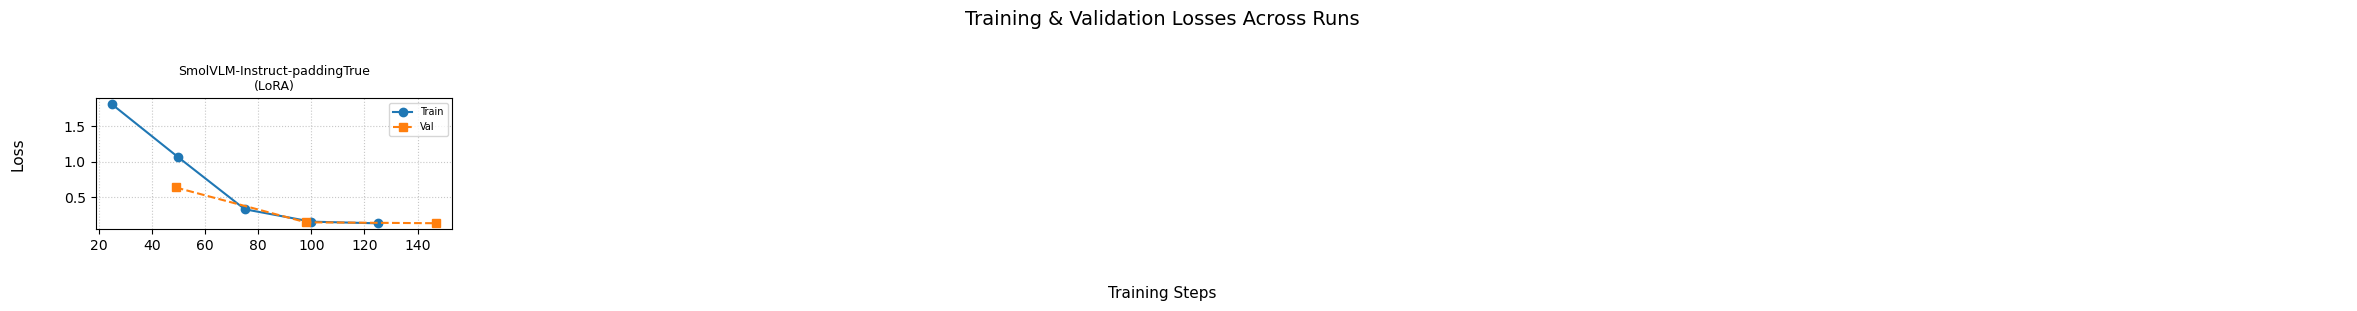

Aggregated plot saved to /home/ricky732/CS7643_final_project/working_dir/smolvlm-chartllama-sft-refactored-short-prompt_aggregated_loss_curves.png


In [43]:
# aggregate and plot loss curves

print("--- Aggregating and Plotting Loss Curves ---")

BASE_OUTPUT_DIR = Path(WORKING_DIR)
OUTPUT_FOLDER_PREFIX = OUTPUT_DIR_BASE_NAME
STATE_FILENAME = "trainer_state.json"

search_pattern = f"{OUTPUT_FOLDER_PREFIX}*/{STATE_FILENAME}"
state_files = list(BASE_OUTPUT_DIR.glob(search_pattern))

if not state_files:
    raise FileNotFoundError("No trainer state files found.")

run_data = []
max_loss = 0

for file_path in state_files:
    run_label = file_path.parent.name.replace(f"{OUTPUT_FOLDER_PREFIX}-", "")

    if run_label.endswith("-full-tuned"):
        method = "Full"
    elif run_label.endswith("-lora-tuned"):
        method = "LoRA"
    elif run_label.endswith("-qlora-tuned"):
        method = "QLoRA"
    else:
        method = "LoRA"

    run_label = run_label.replace("-full-tuned", "").replace("-lora-tuned", "").replace("-qlora-tuned", "")

    with open(file_path, 'r') as f:
        log_history = json.load(f).get("log_history", [])

    df = pd.DataFrame(log_history)
    train_df = df[df['loss'].notna() & df['step'].notna()]
    val_df = df[df['eval_loss'].notna() & df['step'].notna()]

    if not train_df.empty:
        max_loss = max(max_loss, train_df['loss'].max())
    if not val_df.empty:
        max_loss = max(max_loss, val_df['eval_loss'].max())

    run_data.append((run_label, train_df, val_df, method))

run_data.sort(key=lambda x: x[0])

ncols = 6
nrows = math.ceil(len(run_data) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), sharey=True, squeeze=False)

for ax, (label, train_df, val_df, method) in zip(axes.flatten(), run_data):
    if not train_df.empty:
        ax.plot(train_df['step'], train_df['loss'], label='Train', linestyle='-', marker='o')
    if not val_df.empty:
        ax.plot(val_df['step'], val_df['eval_loss'], label='Val', linestyle='--', marker='s')

    ax.set_title(f"{label}\n({method})", fontsize=9)
    ax.legend(fontsize=7)
    ax.grid(True, linestyle=':', alpha=0.7)

for ax in axes.flatten()[len(run_data):]:
    ax.axis('off')

fig.suptitle("Training & Validation Losses Across Runs", fontsize=14)
fig.supxlabel("Training Steps", fontsize=11)
fig.supylabel("Loss", fontsize=11)
fig.tight_layout(rect=[0.02, 0.02, 1, 0.96])

plot_path = BASE_OUTPUT_DIR / f"{OUTPUT_FOLDER_PREFIX}_aggregated_loss_curves.png"
fig.savefig(plot_path, dpi=300)
plt.show()

print(f"Aggregated plot saved to {plot_path}")

In [44]:
# After loading processor = AutoProcessor.from_pretrained(...)
# And after the if block checking for None pad_token_id

print(f"Using Tokenizer: {type(processor.tokenizer)}")
print(f"  pad_token: '{processor.tokenizer.pad_token}'")
print(f"  pad_token_id: {processor.tokenizer.pad_token_id}")
print(f"  eos_token: '{processor.tokenizer.eos_token}'")
print(f"  eos_token_id: {processor.tokenizer.eos_token_id}")
# Optional: Check if processor itself has pad_token attribute
if hasattr(processor, 'pad_token'):
    print(f"  Processor object pad_token attribute: '{processor.pad_token}'")

Using Tokenizer: <class 'transformers.models.gpt2.tokenization_gpt2_fast.GPT2TokenizerFast'>
  pad_token: '<|im_end|>'
  pad_token_id: 2
  eos_token: '<end_of_utterance>'
  eos_token_id: 49154
